<a href="https://colab.research.google.com/github/albertost85/RoboticArm/blob/main/notebooks/dibujar_gr%C3%A1ficas_tensorboard2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar dependencias y funciones

In [2]:
!pip install stable-baselines3[extra]

     |████████████████████████████████| 174 kB 33.8 MB/s 


In [3]:
import os 
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Función obtener los datos

In [4]:
def get_section_results(folder, title=None):
  if title == None:
    title = title=list(filter(lambda x: x != "", folder.split("/")))[-1]
  """
    requires tensorflow==1.12.0
	no sé
  """
  dataset = {"title":title}
  ev_rew = {"X":[],"Y":[]}
  ev_len = {"X":[],"Y":[]} 
  tr_rew = {"X":[],"Y":[]} 
  tr_len = {"X":[],"Y":[]} 
  for path, currentDirectory, files in os.walk(folder):
    for file in files:
      file = os.path.join(folder, file)
      for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
          if v.tag == 'rollout/ep_rew_mean':
            tr_rew["Y"].append(v.simple_value)
            tr_rew["X"].append(e.step)
          if v.tag == 'rollout/ep_len_mean':
            tr_len["Y"].append(v.simple_value)
            tr_len["X"].append(e.step)
          if v.tag == 'eval/mean_reward':
            ev_len["Y"].append(v.simple_value)
            ev_len["X"].append(e.step)
          if v.tag == 'eval/mean_ep_length':
            ev_len["Y"].append(v.simple_value)
            ev_len["X"].append(e.step)
  dataset.update({"ev_rew": {"x":np.array(ev_rew["X"]), "y":np.array(ev_rew["Y"])}, "ev_len": {"x":np.array(ev_len["X"]), "y":np.array(ev_len["Y"])}, "tr_rew": {"x":np.array(tr_rew["X"]), "y":np.array(tr_rew["Y"])}, "tr_len": {"x":np.array(tr_len["X"]), "y":np.array(tr_len["Y"])}})
  fakevec = dataset["tr_len"]["x"].argsort()
  dataset["tr_len"]["x"]=dataset["tr_len"]["x"][fakevec]
  dataset["tr_len"]["y"]=dataset["tr_len"]["y"][fakevec]
  fakevec = dataset["tr_rew"]["x"].argsort()
  dataset["tr_rew"]["x"]=dataset["tr_rew"]["x"][fakevec]
  dataset["tr_rew"]["y"]=dataset["tr_rew"]["y"][fakevec]
  fakevec = dataset["ev_len"]["x"].argsort()
  dataset["ev_len"]["x"]=dataset["ev_len"]["x"][fakevec]
  dataset["ev_len"]["y"]=dataset["ev_len"]["y"][fakevec]
  fakevec = dataset["ev_rew"]["x"].argsort()
  dataset["ev_rew"]["x"]=dataset["ev_rew"]["x"][fakevec]
  dataset["ev_rew"]["y"]=dataset["ev_rew"]["y"][fakevec]
  
  return dataset




# Función dibujar

```
# Tiene formato de código
```



In [9]:
cm = 1/2.54

COLORES = np.array([[0, 0.4470, 0.7410], [0.8500, 0.3250, 0.0980],[0.9290, 0.6940, 0.1250],[0.4940, 0.1840, 0.5560],[0.4660, 0.6740, 0.1880]])
LINEWIDTH = 3*0.8
AXISWIDTH = 3*0.6
MARKERSIZE = 12
PAPERPOSITION = 3*cm*np.array([0, 0, 7.8, 4.8])
#FONTTYPE = 'Times New Roman'
FONTTYPE = 'Verdana'
FONTTYPE2 = FONTTYPE
FONTSIZE_TITLE = 2.5*9
FONTSIZE_AXIS = 2.5*9
FONTSIZE_CONTOUR = 2.5*7
FONTSIZE_LEGEND = FONTSIZE_CONTOUR
FONTSTYLE = 'normal'
FONTSTYLE_TITLE = 'bold'
#PATHIMAGES = './Images' #No poner la barra al final
PATHIMAGES = '/content/drive/MyDrive/Colab Notebooks/Images'
plt.rcParams["font.family"] = FONTTYPE # global font

# Other font possible
csfont = {'fontname': FONTTYPE2}

font_grid = {'fontname': FONTTYPE2,
        'family' : 'normal',
        'weight' : 'bold',
        'size'   : FONTSIZE_CONTOUR }
plt.rc('xtick', labelsize=FONTSIZE_CONTOUR)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONTSIZE_CONTOUR)    # fontsize of the tick labels

# example: plt.title('title',**csfont)


def cute_figure(fig_x, fig_y, name="default_name", file_name = None, labels=None, data_name = None, time_name = 'steps'):
    if file_name == None:
      file_name = name
    if(len(fig_y) > 1):
      dim_y = len(fig_y)
    elif len(fig_y) == 1:
      dim_y = 1
    else:
      dim_y = 0
      

    if labels == None:
        labelstext = "".join(f"Data {i}/" for i in range(dim_y))
        labelstext = labels.split('/')
    else:
        labelstext = labels

    figure = plt.figure(figsize=(PAPERPOSITION[2], PAPERPOSITION[3]))
    figure.suptitle(name, fontsize=FONTSIZE_TITLE, fontweight=FONTSTYLE_TITLE)
    #print(f"ydim {dim_y}") #debug
    
    for i in range(dim_y):
        plt.plot(fig_x[i], fig_y[i], color=COLORES[i], linewidth=LINEWIDTH, label = labelstext[i])
        #print(f"x:{fig_x}, y:{fig_y}, i:{i}")

    if time_name != None:
        plt.xlabel(time_name, fontname=FONTTYPE, fontsize=FONTSIZE_AXIS, fontweight='normal')
    if data_name != None:
        plt.ylabel(data_name, fontsize=FONTSIZE_AXIS, fontweight='normal')

    ax = plt.gca()

    if labels != None:
        plt.legend(fontsize=FONTSIZE_LEGEND, shadow = True, framealpha = None)

    ax.grid(linestyle='--', linewidth=AXISWIDTH)
    # change all spines
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(AXISWIDTH)
    ax.tick_params(width=AXISWIDTH)

    if not os.path.exists(PATHIMAGES):
        os.makedirs(PATHIMAGES)

    if file_name != None:
      result = plt.savefig(f"{PATHIMAGES}/{file_name}_{data_name}.tiff", dpi=300, facecolor='w', edgecolor='w',
              orientation='portrait', format='tiff',
              transparent=False, bbox_inches=None, pad_inches=0.1)
      result = plt.savefig(f"{PATHIMAGES}/{file_name}_{data_name}.eps", facecolor='w', edgecolor='w',
                  orientation='portrait', format='eps',
                  transparent=False, bbox_inches=None, pad_inches=0.1)
    plt.show()
    return figure
#print(A2C_easy_mode2["tr_len"]["x"][-1]) Muchos steps me parecía que había
#cute_figure(A2C_easy_mode2["tr_len"]["x"], A2C_easy_mode2["tr_len"]["y"], name='A2C_easy_mode2', labels = None, data_name = 'ep_mean_length')
#cute_figure(A2C_easy_mode2["tr_rew"]["x"], A2C_easy_mode2["tr_rew"]["y"], name='A2C_easy_mode2', labels = None, data_name = 'ep_mean_reward')


# Script

In [6]:
## Test porque algunos ficheros se importan en orden incorrecto y quedan unas líneas raras en la gráfica.
# fakevec = reach_target_SAC_MlpPolicy_pi64e4_qf128e3_mode2_seed0["tr_len"]["x"].argsort()
# reach_target_SAC_MlpPolicy_pi64e4_qf128e3_mode2_seed0["tr_len"]["x"]=reach_target_SAC_MlpPolicy_pi64e4_qf128e3_mode2_seed0["tr_len"]["x"][fakevec]
# reach_target_SAC_MlpPolicy_pi64e4_qf128e3_mode2_seed0["tr_len"]["y"]=reach_target_SAC_MlpPolicy_pi64e4_qf128e3_mode2_seed0["tr_len"]["y"][fakevec]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


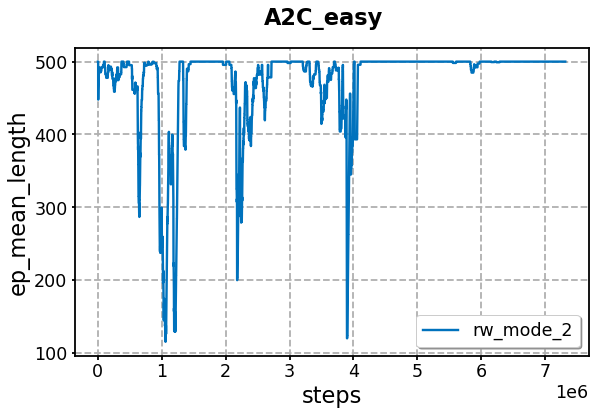

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


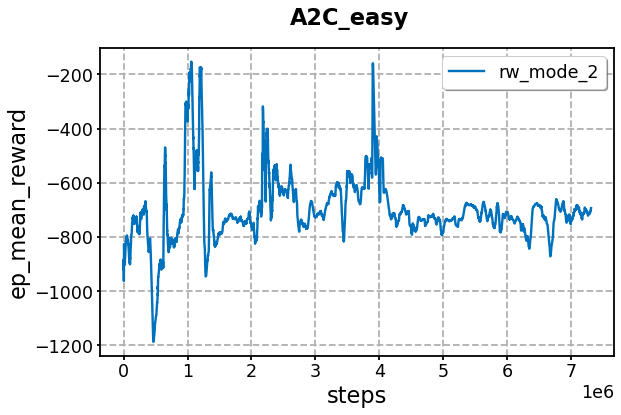

Check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [13]:
#A2C_easy_mode2

log_path_A2C_easy_mode2=os.path.join('/content/drive/MyDrive/Colab Notebooks/A2C_easy_mode2_1')
A2C_easy_mode2 = get_section_results(log_path_A2C_easy_mode2)
my_dataset = A2C_easy_mode2
my_name = log_path_A2C_easy_mode2.split("/")[-1][:- 8].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset["tr_len"]["x"]],
            [my_dataset["tr_len"]["y"]], 
            name=my_name, 
            labels = ['rw_mode_2'], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset["tr_rew"]["x"]], 
            [my_dataset["tr_rew"]["y"]], 
            name=my_name, 
            labels = ['rw_mode_2'], 
            data_name = 'ep_mean_reward')
print(f"Check {PATHIMAGES} for printed images")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


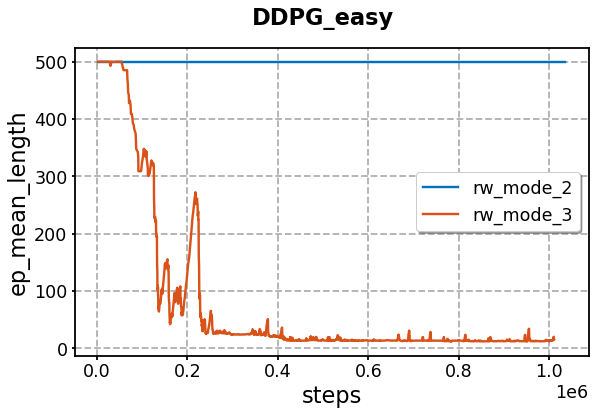

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


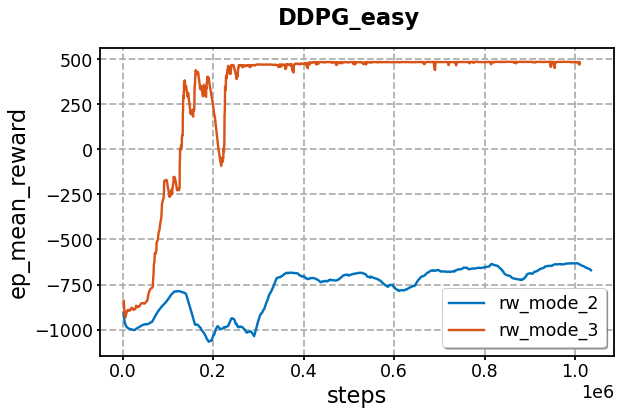

Check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [14]:
#DDPG_easy_mode2

log_path_DDPG_easy_mode2 =os.path.join('/content/drive/MyDrive/Colab Notebooks/DDPG_easy_mode2_1')
DDPG_easy_mode2 = get_section_results(log_path_DDPG_easy_mode2)

#DDPG_easy_mode3

log_path_DDPG_easy_mode3 =os.path.join('/content/drive/MyDrive/Colab Notebooks/DDPG_easy_mode3_1')
DDPG_easy_mode3 = get_section_results(log_path_DDPG_easy_mode3)

#DDPG_easy
my_dataset_mode2 = DDPG_easy_mode2
my_dataset_mode3 = DDPG_easy_mode3
my_name = log_path_DDPG_easy_mode3.split("/")[-1][:- 8].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Check {PATHIMAGES} for printed images")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


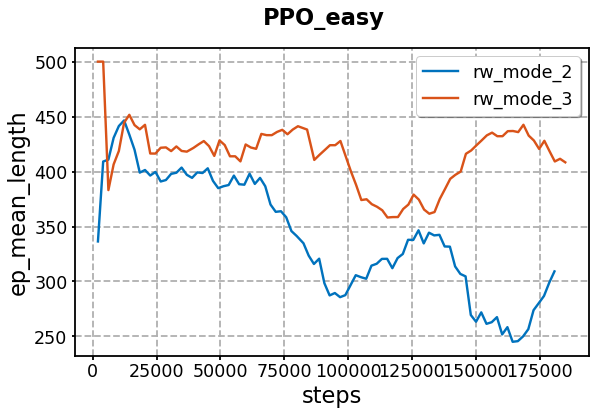

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


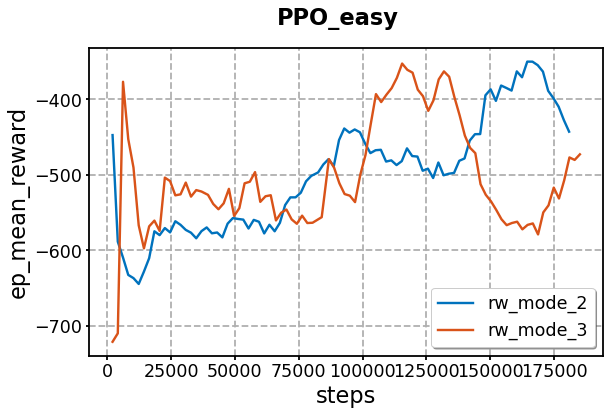

Check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [17]:
##PPO_easy_mode2

log_path_PPO_easy_mode2 =os.path.join('/content/drive/MyDrive/Colab Notebooks/PPO_easy_mode2_1')
PPO_easy_mode2 = get_section_results(log_path_PPO_easy_mode2)

##PPO_easy_mode3

log_path_PPO_easy_mode3 =os.path.join('/content/drive/MyDrive/Colab Notebooks/PPO_easy_mode3_1')
PPO_easy_mode3 = get_section_results(log_path_PPO_easy_mode3)


##PPO_easy
my_dataset_mode2 = PPO_easy_mode2
my_dataset_mode3 = PPO_easy_mode3
my_name = log_path_PPO_easy_mode2.split("/")[-1][:- 8].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Check {PATHIMAGES} for printed images")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


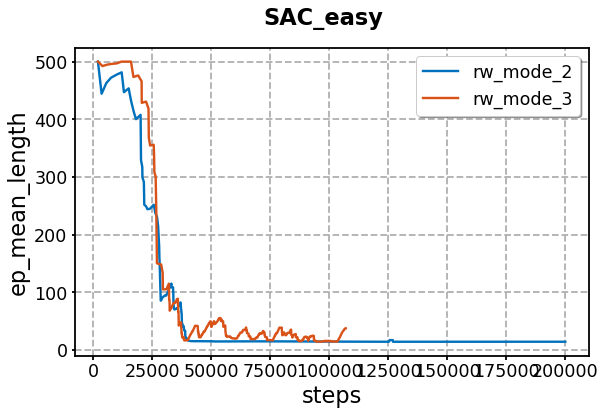

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


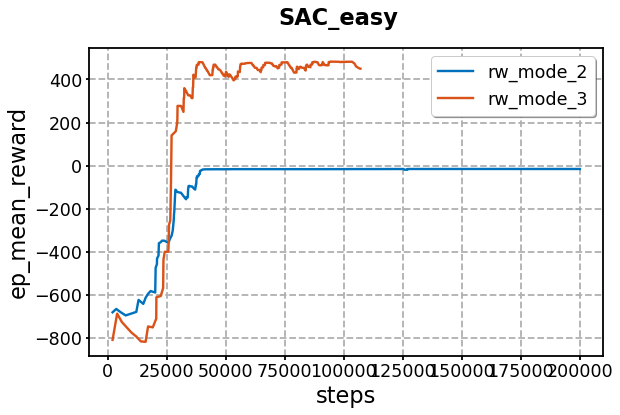

Check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [18]:
#log_path_SAC_easy_mode2

log_path_SAC_easy_mode2 =os.path.join('/content/drive/MyDrive/Colab Notebooks/SAC_easy_mode2_1')
SAC_easy_mode2 = get_section_results(log_path_SAC_easy_mode2)

#log_path_SAC_easy_mode3

log_path_SAC_easy_mode3 =os.path.join('/content/drive/MyDrive/Colab Notebooks/SAC_easy_mode3_2')
SAC_easy_mode3 = get_section_results(log_path_SAC_easy_mode3)

#SAC_easy
my_dataset_mode2 = SAC_easy_mode2
my_dataset_mode3 = SAC_easy_mode3
my_name = log_path_SAC_easy_mode2.split("/")[-1][:- 8].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Check {PATHIMAGES} for printed images")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


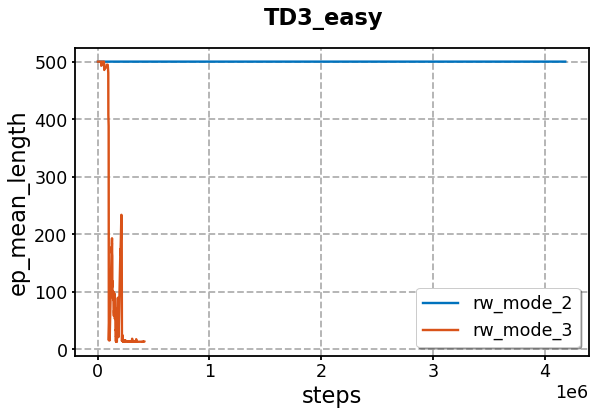

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


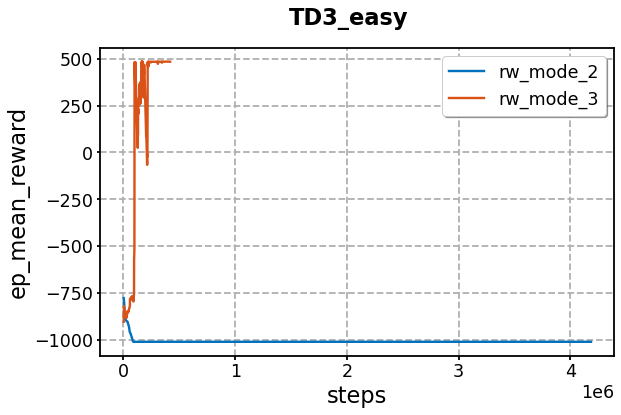

Check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [19]:
#log_path_TD3_easy_mode2

log_path_TD3_easy_mode2 =os.path.join('/content/drive/MyDrive/Colab Notebooks/TD3_easy_mode2_1')
TD3_easy_mode2 = get_section_results(log_path_TD3_easy_mode2)

#log_path_TD3_easy_mode3

log_path_TD3_easy_mode3 =os.path.join('/content/drive/MyDrive/Colab Notebooks/TD3_easy_mode3_1')
TD3_easy_mode3 = get_section_results(log_path_TD3_easy_mode3)

#TD3_easy
my_dataset_mode2 = TD3_easy_mode2
my_dataset_mode3 = TD3_easy_mode3
my_name = log_path_TD3_easy_mode2.split("/")[-1][:- 8].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Check {PATHIMAGES} for printed images")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


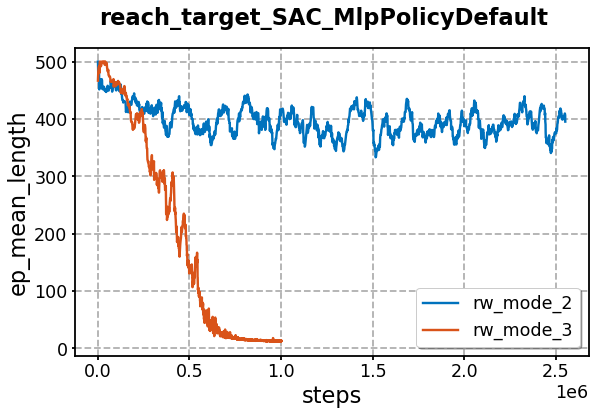

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


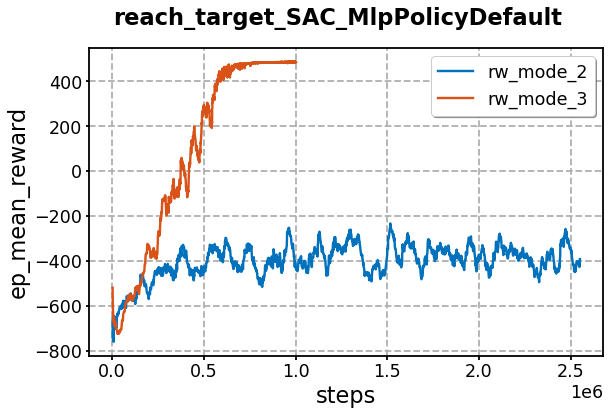

Name: reach_target_SAC_MlpPolicyDefault, check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [22]:
#reach_target_SAC_MlpPolicyDefault
path_mode2 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[Default]_mode2_seed=0_0'
path_mode3 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[Default]_mode3_seed=0_0'
my_dataset_mode2 = get_section_results(path_mode2)
my_dataset_mode3 = get_section_results(path_mode3)
my_name = path_mode2.split("/")[-1][:- 15].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Name: {my_name}, check {PATHIMAGES} for printed images")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


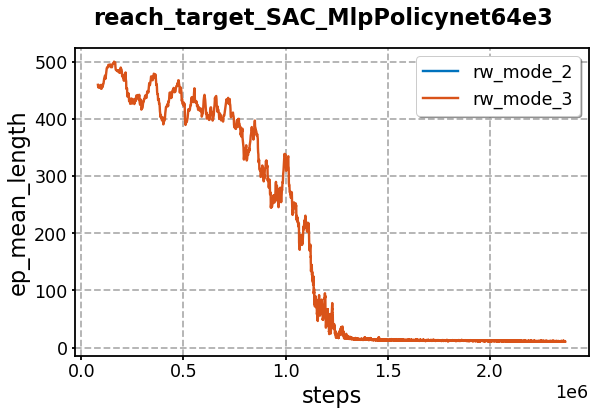

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


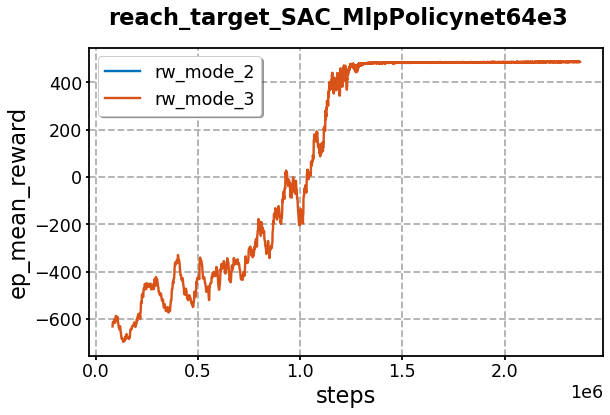

Name: reach_target_SAC_MlpPolicynet64e3, check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [25]:
#reach_target_SAC_MlpPolicy[net=64e3]_mode3_seed=0_0
path_mode2 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[net=64e3]_mode2_seed=0_0'
path_mode3 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[net=64e3]_mode3_seed=0_0' #tarda mucho, hay demasiados logs
my_dataset_mode2 = get_section_results(path_mode2)
my_dataset_mode3 = get_section_results(path_mode3)
my_name = path_mode2.split("/")[-1][:- 15].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Name: {my_name}, check {PATHIMAGES} for printed images")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


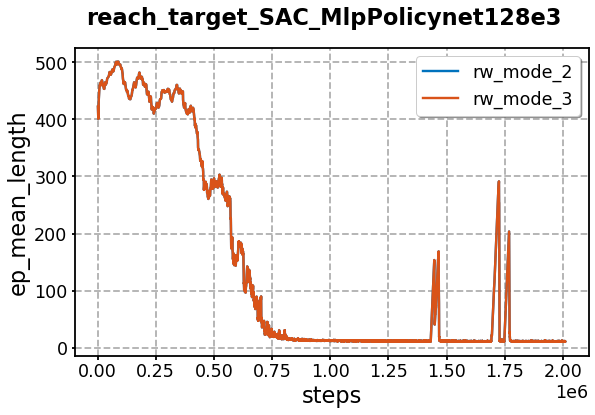

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


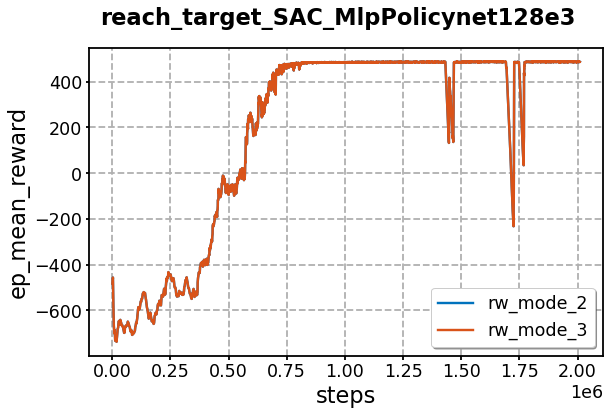

Name: reach_target_SAC_MlpPolicynet128e3, check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [28]:
#reach_target_SAC_MlpPolicynet128e3
path_mode2 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[net=128e3]_mode2_seed=0_0'
path_mode3 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[net=128e3]_mode3_seed=0_0' #tarda mucho, hay demasiados logs
my_dataset_mode2 = get_section_results(path_mode2)
my_dataset_mode3 = get_section_results(path_mode3)
my_name = path_mode2.split("/")[-1][:- 15].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Name: {my_name}, check {PATHIMAGES} for printed images")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


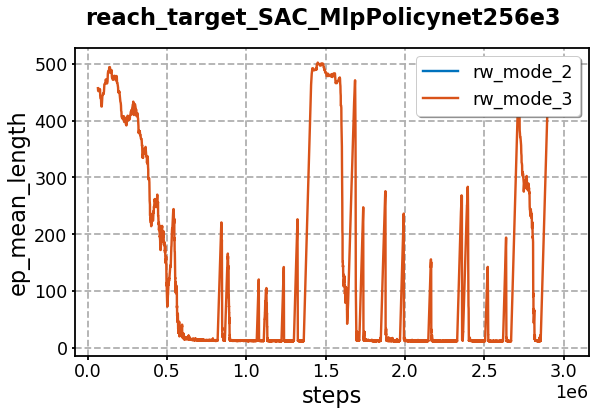

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


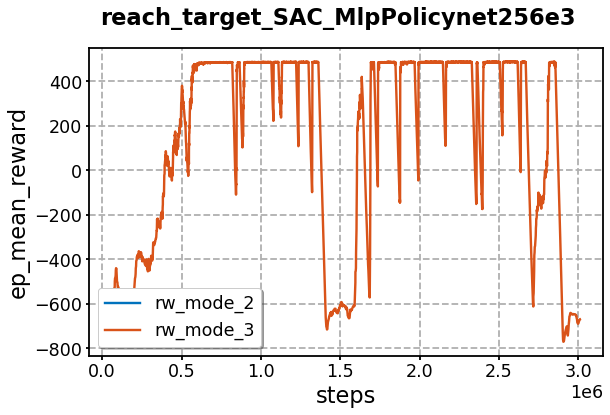

Name: reach_target_SAC_MlpPolicynet256e3, check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [31]:
#reach_target_SAC_MlpPolicy[net=256e3]_mode3_seed=0_0
path_mode2 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[net=256e3]_mode2_seed=0_0'
path_mode3 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[net=256e3]_mode3_seed=0_0' #tarda mucho, hay demasiados logs
my_dataset_mode2 = get_section_results(path_mode2)
my_dataset_mode3 = get_section_results(path_mode3) #muchos logs
my_name = path_mode2.split("/")[-1][:- 15].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Name: {my_name}, check {PATHIMAGES} for printed images")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


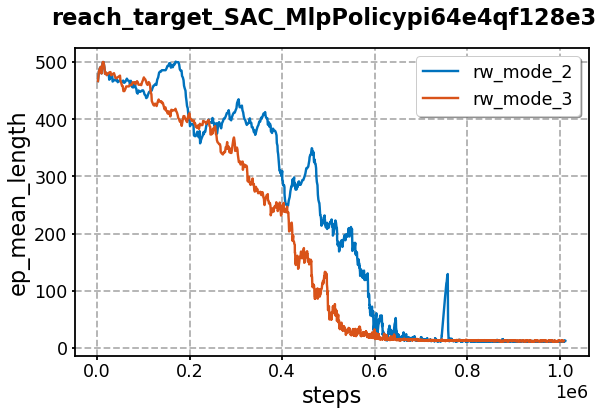

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


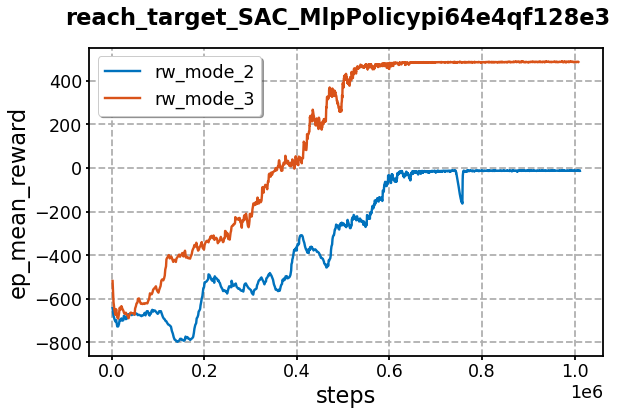

Name: reach_target_SAC_MlpPolicypi64e4qf128e3, check /content/drive/MyDrive/Colab Notebooks/Images for printed images


In [21]:
#reach_target_SAC_MlpPolicypi64e4qf128e3
path_mode2 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[pi=64e4-qf=128e3]_mode2_seed=0_0'
path_mode3 = '/content/drive/MyDrive/Colab Notebooks/reach_target_SAC_MlpPolicy[pi=64e4-qf=128e3]_mode3_seed=0_0'
my_dataset_mode2 = get_section_results(path_mode2)
my_dataset_mode3 = get_section_results(path_mode3)
my_name = path_mode2.split("/")[-1][:- 15].replace('=','').replace('[','').replace(']','').replace('-','')
cute_figure([my_dataset_mode2["tr_len"]["x"],
             my_dataset_mode3["tr_len"]["x"]],
            [my_dataset_mode2["tr_len"]["y"],
             my_dataset_mode3["tr_len"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_length')
cute_figure([my_dataset_mode2["tr_rew"]["x"],
             my_dataset_mode3["tr_rew"]["x"]],
            [my_dataset_mode2["tr_rew"]["y"],
             my_dataset_mode3["tr_rew"]["y"]],
            name=my_name, 
            labels = ["rw_mode_2","rw_mode_3"], 
            data_name = 'ep_mean_reward')
print(f"Name: {my_name}, check {PATHIMAGES} for printed images")

# Dibujar datos con errorbar (despreciado)

In [3]:
"""
fig1_std = plt.figure(dpi=1000)
yerr1 = np.std(y1)
yerr2 = np.std(y2)
yerr3 = np.std(y3)
yerr4 = np.std(y4)
plt.errorbar(X1, y1, yerr1)
plt.errorbar(X2, y2, yerr2)
plt.errorbar(X3, y3, yerr3)
plt.errorbar(X4, y4, yerr4)
plt.title("CartPole_Bullet")
plt.ylabel('reward')
plt.xlabel('time steps')
#plt.legend(loc='lower right')
plt.grid()
"""

'\nfig1_std = plt.figure(dpi=1000)\nyerr1 = np.std(y1)\nyerr2 = np.std(y2)\nyerr3 = np.std(y3)\nyerr4 = np.std(y4)\nplt.errorbar(X1, y1, yerr1)\nplt.errorbar(X2, y2, yerr2)\nplt.errorbar(X3, y3, yerr3)\nplt.errorbar(X4, y4, yerr4)\nplt.title("CartPole_Bullet")\nplt.ylabel(\'reward\')\nplt.xlabel(\'time steps\')\n#plt.legend(loc=\'lower right\')\nplt.grid()\n'